## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Sun May 22 16:59:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:08:00.0 Off |                  N/A |
| 23%   24C    P2    57W / 250W |   3285MiB / 11178MiB |     12%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [6]:
def train(pred, opt, train_dataset, train_loader, val_dataset, val_loader):
    device = torch.device('cuda:0')
    pred = pred.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(50):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            #print(preds)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()

        train_loss = np.sqrt(total_loss / len(train_dataset))
        val_loss = np.sqrt(val_loss / len(val_dataset))

        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 7811.592658035867 val_loss: 692.6996331240215
epoch 1 train_loss: 474.55759982232064 val_loss: 401.33240381269405
epoch 2 train_loss: 382.3396628768072 val_loss: 379.5548399424472
epoch 3 train_loss: 369.8307736376063 val_loss: 370.81934194913134
epoch 4 train_loss: 365.1271744592637 val_loss: 367.35757765769716
epoch 5 train_loss: 363.0718976125607 val_loss: 368.4823130675711
epoch 6 train_loss: 361.6858001204657 val_loss: 366.7659231683796
epoch 7 train_loss: 360.56382634317123 val_loss: 358.3217514991749
epoch 8 train_loss: 359.67287003560784 val_loss: 352.376992385826
epoch 9 train_loss: 357.9877666180916 val_loss: 350.18059620493796
epoch 10 train_loss: 355.9582090176653 val_loss: 351.19890318264106
epoch 11 train_loss: 354.1526570666532 val_loss: 354.4291640989704
epoch 12 train_loss: 352.6811730751167 val_loss: 356.4531076594126
epoch 13 train_loss: 351.15009207749483 val_loss: 357.038178804891
epoch 14 train_loss: 349.0265262776683 val_loss: 357

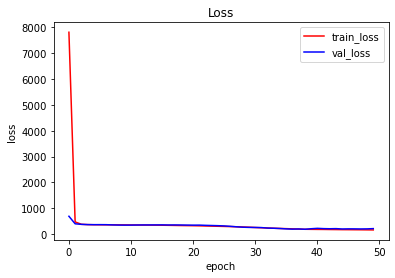

city: miami
epoch 0 train_loss: 16858.81290331992 val_loss: 1284.7080673499727
epoch 1 train_loss: 714.7032109993114 val_loss: 465.0874848374984
epoch 2 train_loss: 415.1918393246975 val_loss: 377.0103628758008
epoch 3 train_loss: 367.8654013427937 val_loss: 349.05506260264843
epoch 4 train_loss: 349.3257082237049 val_loss: 342.68124667312094
epoch 5 train_loss: 340.63131286614504 val_loss: 332.2698135460932
epoch 6 train_loss: 335.66731432505884 val_loss: 337.4697635696823
epoch 7 train_loss: 334.63504442030177 val_loss: 345.2195158534304
epoch 8 train_loss: 335.2799318336232 val_loss: 337.5131185840719
epoch 9 train_loss: 335.6212591680289 val_loss: 322.0912423364436
epoch 10 train_loss: 331.1033843684743 val_loss: 312.29248488365556
epoch 11 train_loss: 326.3778846291824 val_loss: 310.1635661207454
epoch 12 train_loss: 327.7597582966335 val_loss: 307.2519764120773
epoch 13 train_loss: 328.27103344158496 val_loss: 306.73822724338197
epoch 14 train_loss: 327.40103553025136 val_loss: 3

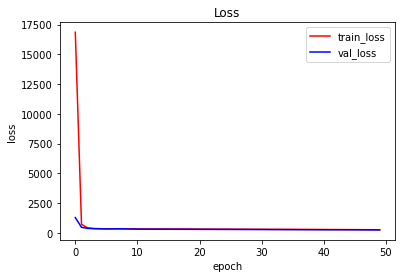

city: pittsburgh
epoch 0 train_loss: 14939.258206955334 val_loss: 3608.8437854137337
epoch 1 train_loss: 1035.0919325282298 val_loss: 353.602692820604
epoch 2 train_loss: 332.06167489654854 val_loss: 320.6251011818808
epoch 3 train_loss: 319.5565098861532 val_loss: 319.79096091192196
epoch 4 train_loss: 317.28344226809196 val_loss: 333.55615006094854
epoch 5 train_loss: 317.2022312038499 val_loss: 335.198416410185
epoch 6 train_loss: 316.7788926433121 val_loss: 314.7011332495514
epoch 7 train_loss: 316.0540650149511 val_loss: 319.1666927838503
epoch 8 train_loss: 316.0004093290671 val_loss: 323.7315984754197
epoch 9 train_loss: 315.7164556896633 val_loss: 327.9381658704224
epoch 10 train_loss: 316.02631796701127 val_loss: 331.9497540240625
epoch 11 train_loss: 316.992705526364 val_loss: 331.41415235625254
epoch 12 train_loss: 318.4371585527947 val_loss: 330.6955244755668
epoch 13 train_loss: 319.14914792628855 val_loss: 330.85581378251374
epoch 14 train_loss: 319.26332853883474 val_los

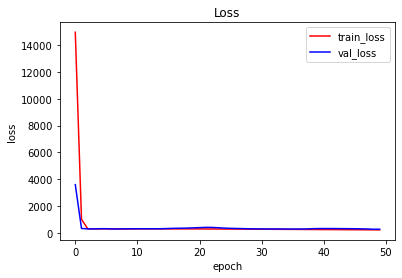

city: dearborn
epoch 0 train_loss: 41926.93152678907 val_loss: 6187.504992751906
epoch 1 train_loss: 2853.244332698766 val_loss: 1340.1222088069126
epoch 2 train_loss: 941.0342556142266 val_loss: 580.4902459572454
epoch 3 train_loss: 548.2412982319904 val_loss: 508.41762973154715
epoch 4 train_loss: 503.9615931170324 val_loss: 491.86672157792947
epoch 5 train_loss: 489.69811036450676 val_loss: 488.51098042533323
epoch 6 train_loss: 484.13480028737916 val_loss: 495.7140485506769
epoch 7 train_loss: 480.7295756460375 val_loss: 514.0007369416824
epoch 8 train_loss: 478.94579064943565 val_loss: 524.5217895555686
epoch 9 train_loss: 477.8670066031133 val_loss: 530.8338037225353
epoch 10 train_loss: 476.8816387607845 val_loss: 534.6575195320445
epoch 11 train_loss: 475.66188921715457 val_loss: 533.7396170320242
epoch 12 train_loss: 474.31602222270396 val_loss: 526.3155122003519
epoch 13 train_loss: 472.83871650467165 val_loss: 511.4455644802021
epoch 14 train_loss: 471.40719854534103 val_los

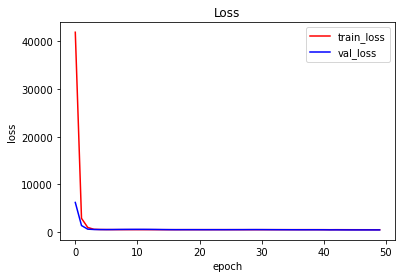

city: washington-dc
epoch 0 train_loss: 21282.997691459284 val_loss: 5496.728911645009
epoch 1 train_loss: 5290.076831084508 val_loss: 4617.2788872190895
epoch 2 train_loss: 2131.078073657238 val_loss: 583.9985061938279
epoch 3 train_loss: 490.40000399681605 val_loss: 414.482132781932
epoch 4 train_loss: 407.14455501982917 val_loss: 376.5429095868901
epoch 5 train_loss: 384.75547737755375 val_loss: 362.999739197788
epoch 6 train_loss: 374.1487933792223 val_loss: 355.2415154736135
epoch 7 train_loss: 367.59493939366297 val_loss: 350.34314425526804
epoch 8 train_loss: 363.75159160110223 val_loss: 347.6279875361256
epoch 9 train_loss: 361.398091722864 val_loss: 346.5462054114396
epoch 10 train_loss: 359.89895592586777 val_loss: 347.1581456256084
epoch 11 train_loss: 358.68214625821764 val_loss: 349.2231887680995
epoch 12 train_loss: 357.3997919787632 val_loss: 350.71550340469366
epoch 13 train_loss: 356.0856067071876 val_loss: 349.87683244537914
epoch 14 train_loss: 354.9910394544874 val_

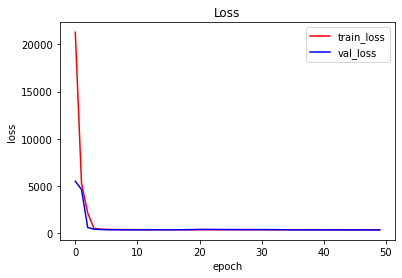

city: palo-alto
epoch 0 train_loss: 14373.898912833147 val_loss: 8784.543012963117
epoch 1 train_loss: 6515.767120818911 val_loss: 3121.1470169946065
epoch 2 train_loss: 1691.5910003397346 val_loss: 783.7540967300017
epoch 3 train_loss: 668.0695885204202 val_loss: 576.5380299520767
epoch 4 train_loss: 548.1789001753473 val_loss: 516.9198893797737
epoch 5 train_loss: 504.0449391173732 val_loss: 486.5156084409897
epoch 6 train_loss: 480.71872807455 val_loss: 468.3365333181701
epoch 7 train_loss: 465.8480681750963 val_loss: 457.59322615592254
epoch 8 train_loss: 455.81572690717076 val_loss: 450.1489661942546
epoch 9 train_loss: 448.66250631209766 val_loss: 443.40427320036986
epoch 10 train_loss: 443.4845809649982 val_loss: 438.1206016367912
epoch 11 train_loss: 439.6176688634863 val_loss: 434.4712409237644
epoch 12 train_loss: 436.4643085626954 val_loss: 431.5289241572748
epoch 13 train_loss: 433.8422569897432 val_loss: 429.23339431544923
epoch 14 train_loss: 431.683531615367 val_loss: 42

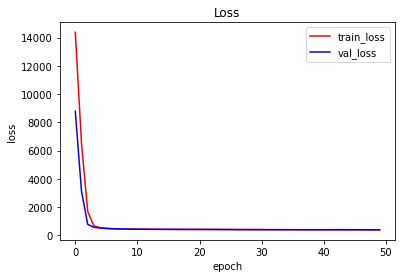

CPU times: user 5min 13s, sys: 10.6 s, total: 5min 23s
Wall time: 5min 23s


In [7]:
%%time
import pickle
#train city models
for city in cities:
    print('city: ' + city)
    batch_sz = 128  # batch size
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    pred = Pred()
    opt = optim.Adam(pred.parameters(), lr=2e-4)
    train(pred, opt, train_dataset, train_loader, val_dataset, val_loader)
    pickle.dump(pred, open('models/mlp_3_layer_' + city + '_small', 'wb'))

In [8]:
import pandas as pd
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    load_pred = pickle.load(open('models/mlp_3_layer_' + city + '_small', 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [9]:
all_predictions

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-33.085537,-564.774780,-33.407417,-563.317749,-33.878307,-565.007996,-33.798672,-568.307861,-33.771355,...,-33.516922,-565.120605,-32.379631,-565.743530,-36.534435,-564.978394,-33.494011,-565.692078,-32.804050,-563.689941
1,1_austin,-346.405640,-10.947014,-346.419678,-10.258338,-348.201447,-10.356225,-346.205383,-10.432265,-348.924377,...,-341.751953,-12.819384,-344.009338,-12.279085,-343.148926,-11.863943,-342.109619,-15.438901,-342.867737,-11.894204
2,2_austin,51.492413,-249.364151,52.755238,-249.211227,52.019024,-249.463074,53.049160,-249.244980,52.980167,...,52.792706,-249.354965,52.499493,-248.809967,52.838566,-250.103088,52.874203,-249.691864,52.079422,-249.347549
3,3_austin,-104.855682,1787.979248,-105.880219,1787.120605,-107.556862,1787.355957,-109.019066,1792.228271,-109.711029,...,-101.904602,1789.964966,-98.458984,1791.104248,-99.114861,1788.773438,-99.900452,1788.699829,-101.613411,1787.957397
4,4_austin,1223.848511,-657.169312,1234.252441,-654.336182,1230.973267,-655.726196,1234.886963,-655.497070,1233.528564,...,1243.059570,-662.393311,1238.193726,-664.733887,1249.175903,-664.287292,1239.751099,-663.107422,1238.401978,-663.549500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1372.088745,-439.148071,-1367.815552,-442.531342,-1378.740112,-443.039398,-1367.861206,-449.434753,-1372.855225,...,-1373.438354,-442.189789,-1372.158203,-441.157166,-1363.949219,-447.610504,-1373.278687,-443.534607,-1374.554810,-443.834473
29839,1682_palo-alto,126.961296,-36.316689,124.860741,-38.012589,127.137520,-36.119587,126.414780,-40.122246,125.548477,...,126.695930,-38.309551,126.840683,-36.034031,125.813507,-35.045052,126.902557,-35.641644,125.234299,-36.097160
29840,1683_palo-alto,-1431.718750,2178.587646,-1439.504761,2180.623291,-1440.685547,2177.243896,-1433.946899,2178.880859,-1432.132324,...,-1431.826416,2177.602539,-1437.477295,2183.391846,-1440.544312,2189.803955,-1433.669434,2192.062012,-1436.523682,2182.896729
29841,1684_palo-alto,1055.392822,1390.407471,1044.511963,1390.862183,1052.257935,1391.134888,1050.849365,1396.537598,1047.685547,...,1057.409180,1396.561157,1048.225464,1399.207642,1049.315918,1400.305298,1050.247925,1392.154785,1042.607544,1397.838745


In [10]:
all_predictions.to_csv('out.csv', index=False)

In [11]:
pd.read_csv('out.csv')

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-33.085537,-564.774800,-33.407417,-563.317750,-33.878307,-565.008000,-33.798670,-568.307860,-33.771355,...,-33.516922,-565.120600,-32.379630,-565.743500,-36.534435,-564.978400,-33.494010,-565.692100,-32.804050,-563.689940
1,1_austin,-346.405640,-10.947014,-346.419680,-10.258338,-348.201450,-10.356225,-346.205380,-10.432265,-348.924380,...,-341.751950,-12.819384,-344.009340,-12.279085,-343.148930,-11.863943,-342.109620,-15.438901,-342.867740,-11.894204
2,2_austin,51.492413,-249.364150,52.755238,-249.211230,52.019024,-249.463070,53.049160,-249.244980,52.980167,...,52.792706,-249.354970,52.499493,-248.809970,52.838566,-250.103090,52.874203,-249.691860,52.079422,-249.347550
3,3_austin,-104.855680,1787.979200,-105.880220,1787.120600,-107.556860,1787.356000,-109.019066,1792.228300,-109.711030,...,-101.904600,1789.965000,-98.458984,1791.104200,-99.114860,1788.773400,-99.900450,1788.699800,-101.613410,1787.957400
4,4_austin,1223.848500,-657.169300,1234.252400,-654.336200,1230.973300,-655.726200,1234.887000,-655.497100,1233.528600,...,1243.059600,-662.393300,1238.193700,-664.733900,1249.175900,-664.287300,1239.751100,-663.107400,1238.402000,-663.549500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1372.088700,-439.148070,-1367.815600,-442.531340,-1378.740100,-443.039400,-1367.861200,-449.434750,-1372.855200,...,-1373.438400,-442.189800,-1372.158200,-441.157170,-1363.949200,-447.610500,-1373.278700,-443.534600,-1374.554800,-443.834470
29839,1682_palo-alto,126.961296,-36.316690,124.860740,-38.012590,127.137520,-36.119587,126.414780,-40.122246,125.548480,...,126.695930,-38.309550,126.840680,-36.034030,125.813510,-35.045050,126.902560,-35.641644,125.234300,-36.097160
29840,1683_palo-alto,-1431.718800,2178.587600,-1439.504800,2180.623300,-1440.685500,2177.244000,-1433.946900,2178.880900,-1432.132300,...,-1431.826400,2177.602500,-1437.477300,2183.391800,-1440.544300,2189.804000,-1433.669400,2192.062000,-1436.523700,2182.896700
29841,1684_palo-alto,1055.392800,1390.407500,1044.512000,1390.862200,1052.257900,1391.134900,1050.849400,1396.537600,1047.685500,...,1057.409200,1396.561200,1048.225500,1399.207600,1049.315900,1400.305300,1050.247900,1392.154800,1042.607500,1397.838700
